In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from feature_engine.outliers import Winsorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import KNNImputer

In [2]:
df = pd.read_csv('../Data/df_transformed.csv')

In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
df.columns

Index(['LBXTC', 'RIAGENDR', 'RIDRETH3', 'RIDAGEYR', 'BMXWT', 'BMXHT', 'BMXBMI',
       'BPXPLS', 'BPXPULS', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR',
       'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL',
       'DR1TSODI', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TPOTA', 'DR1_300',
       'ALQ120Q', 'ALQ120U', 'ALQ130', 'BPQ020', 'BPQ050A', 'BPQ080',
       'BPQ100D', 'DIQ010', 'MCQ170M', 'SMQ681', 'PAQ610', 'PAD615', 'PAQ625',
       'PAD630', 'PAQ655', 'PAD660', 'PAQ670', 'PAD675', 'Systolic',
       'Diastolic', 'MET_work', 'MET_rec', 'DR1TKCAL_t', 'DR1TPROT_t',
       'DR1TCARB_t', 'DR1TSUGR_t', 'DR1TFIBE_t', 'DR1TTFAT_t', 'DR1TSFAT_t',
       'DR1TMFAT_t', 'DR1TPFAT_t', 'DR1TCHOL_t', 'DR1TSODI_t', 'DR1TVD_t',
       'DR1TCALC_t', 'DR1TIRON_t', 'DR1TPOTA_t', 'log_LBXTC'],
      dtype='object')

First I'm going to try with demographic information, body mass index, blood pressure, pulse, nutrition info (not transformed) and MET recreational.  Because KNN uses distance, any categorical, non oridnal, values with more than two levels such as race, need to be one hot encoded because we want the distances to be the same between any two races.  I will also first try with y being LBXTC and not log transformed.
I plan to first drop missing values then try it with imputed missing values

In [5]:
numerical_variables = ['RIAGENDR','RIDAGEYR','BMXBMI','BPXPLS','DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR',
       'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL',
       'DR1TSODI', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TPOTA','MET_rec','Systolic','Diastolic']
categorical_variables = ['RIDRETH3','DR1_300']

In [6]:
df1 = df[numerical_variables+categorical_variables+['LBXTC']].copy()

In [7]:
df1.dropna(inplace=True)

In [8]:
y = df1.LBXTC
X = df1.drop('LBXTC', axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=625)

In [10]:
numeric_transformer = Pipeline(steps=[('scalar',MinMaxScaler())])
cat_transformer = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables),
    ('cat',cat_transformer,categorical_variables)])

In [11]:
knn1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('knn_regression', KNeighborsRegressor())])

In [12]:
params = {
    'knn_regression__weights':['uniform', 'distance'],
    'knn_regression__n_neighbors':[1, 2,5,10, 20,50,100]
}

In [21]:
grid1 = GridSearchCV(knn1,params,scoring='neg_root_mean_squared_error',verbose=0)
grid1.fit(X_train,y_train)
grid1.best_params_

{'knn_regression__n_neighbors': 50, 'knn_regression__weights': 'distance'}

In [22]:
grid1.best_score_

-40.93144767151533

In [23]:
y_preds = grid1.predict(X_test)
print('Mean Absolute error for test set:',mean_absolute_error(y_test, y_preds))

Mean Absolute error for test set: 31.957006033023713


The test and train scores are similar. There doesn't appear to be underfitting.  However that is a large MAE.  In context someone with cholesterol level of 170 may in fact have high cholesterol.    Looking at the plot of residuals..

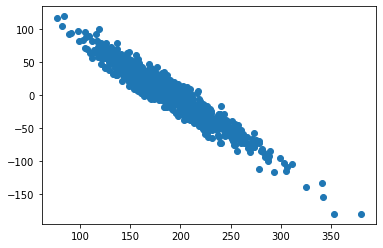

In [24]:
residuals = y_preds-y_test
plt.scatter(y_test,residuals)

Notice this is not a good model.  The residuals should be randomly scattered centered at 0.  Here it shows very large residuals for extreme values of y.  

(array([  2.,   0.,   1.,   2.,   0.,   4.,   3.,   8.,  18.,  19.,  39.,
         50.,  71.,  83.,  99., 113., 107., 109.,  67.,  48.,  35.,  13.,
          7.,   3.,   2.]),
 array([-179.30059676, -167.37885243, -155.4571081 , -143.53536378,
        -131.61361945, -119.69187512, -107.77013079,  -95.84838646,
         -83.92664213,  -72.00489781,  -60.08315348,  -48.16140915,
         -36.23966482,  -24.31792049,  -12.39617616,   -0.47443184,
          11.44731249,   23.36905682,   35.29080115,   47.21254548,
          59.1342898 ,   71.05603413,   82.97777846,   94.89952279,
         106.82126712,  118.74301145]),
 <BarContainer object of 25 artists>)

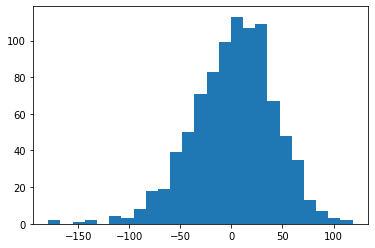

In [25]:
plt.hist(residuals,bins=25)

The histogram of the residuals is left skewed.  

Going to try now with the log transformed dependant variable.

In [26]:
df2 = df[numerical_variables+categorical_variables+['log_LBXTC']].copy()
df2.dropna(inplace=True)
y = df2.log_LBXTC
X = df2.drop('log_LBXTC', axis=1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=625)
preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables),
    ('cat',cat_transformer,categorical_variables)])
knn2 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('knn_regression', KNeighborsRegressor())])
grid2 = GridSearchCV(knn2,params,scoring='neg_root_mean_squared_error',verbose=0)
grid2.fit(X_train,y_train)
grid2.best_params_

{'knn_regression__n_neighbors': 50, 'knn_regression__weights': 'distance'}

In [28]:
grid2.best_score_

-0.21260357841831823

This RMSE is much better.  Looking at residuals

In [29]:
y_preds = grid2.predict(X_test)
print('Mean Absolute error for test set:',mean_absolute_error(y_test, y_preds))

Mean Absolute error for test set: 0.17012329832203174


In [30]:
10**0.17012329832203174

1.4795283738703189

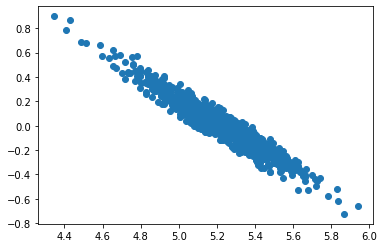

In [31]:
residuals = y_preds-y_test
plt.scatter(y_test,residuals)

The residual plot still shows that the model struggles to capture extreme values.  More variables may be needed.  But before adding variables I want to try with the transformed nutrition information.  

I still need to try imputing values as well
and maybe cutting the outliers on y out

In [40]:
numerical_variables = ['RIAGENDR','RIDAGEYR','BMXBMI','BPXPLS','DR1TKCAL_t', 'DR1TPROT_t',
       'DR1TCARB_t', 'DR1TSUGR_t', 'DR1TFIBE_t', 'DR1TTFAT_t', 'DR1TSFAT_t',
       'DR1TMFAT_t', 'DR1TPFAT_t', 'DR1TCHOL_t', 'DR1TSODI_t', 'DR1TVD_t',
       'DR1TCALC_t', 'DR1TIRON_t', 'DR1TPOTA_t','MET_rec','Systolic','Diastolic']
categorical_variables = ['RIDRETH3']

In [41]:
df3 = df[numerical_variables+categorical_variables+['LBXTC']].copy()

In [42]:
df3.dropna(inplace=True)

In [43]:
y = df3.LBXTC
X = df3.drop('LBXTC', axis=1)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=625)

In [45]:
numeric_transformer = Pipeline(steps=[('scalar',MinMaxScaler())])
cat_transformer = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables),
    ('cat',cat_transformer,categorical_variables)])
knn3 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('knn_regression', KNeighborsRegressor())])

In [46]:
grid3 = GridSearchCV(knn3,params,scoring='neg_mean_absolute_error',verbose=0)
grid3.fit(X_train,y_train)
grid3.best_params_

{'knn_regression__n_neighbors': 50, 'knn_regression__weights': 'distance'}

In [47]:
grid3.best_score_

-31.087005868896107

Again the MAE is high.  Looking at the residuals

In [48]:
y_preds = grid3.predict(X_test)
print('Mean Absolute error for test set:',mean_absolute_error(y_test, y_preds))

Mean Absolute error for test set: 31.57370517649879


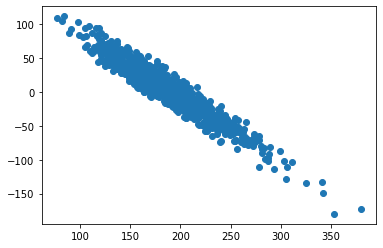

In [49]:
residuals = y_preds-y_test
plt.scatter(y_test,residuals)

Again the model is not fittinng well, values farther away than a cholesterol of 200 have large MAE.  Going to try adding a step of windsorizing outliers, then I will add chronic conditions.

In [50]:
numeric_transformer = Pipeline(steps=[('scalar',MinMaxScaler()),('winsorizor',Winsorizer(capping_method='iqr',tail='right'))])
cat_transformer = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables),
    ('cat',cat_transformer,categorical_variables)])
knn4 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('knn_regression', KNeighborsRegressor())])

In [51]:
grid4 = GridSearchCV(knn4,params,scoring='neg_root_mean_squared_error',verbose=0)
grid4.fit(X_train,y_train)
grid4.best_params_

{'knn_regression__n_neighbors': 50, 'knn_regression__weights': 'distance'}

In [52]:
grid4.best_score_

-40.37750468470519

In [53]:
y_preds = grid4.predict(X_test)
print('Mean Absolute error for test set:',mean_absolute_error(y_test, y_preds))

Mean Absolute error for test set: 31.552106739956137


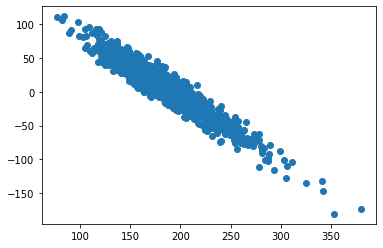

In [54]:
residuals = y_preds-y_test
plt.scatter(y_test,residuals)

In [ ]:
# Next add chronic conditions, smoking, and alcohol use
# Then try by removing outliers from the y
# for the model you do want to include those with high cholesterol but for the product may want to ignore.